## This notebook shows how to run a whole lot of propagations

In [1]:
from adam import Batch
from adam import PropagationParams
from adam import OpmParams
from adam import BatchRunManager
from adam import ConfigManager
from adam import Service
from adam.batch_run_manager import State
from adam.timer import Timer

import datetime
import os
import tabulate

from IPython.display import display, clear_output

import numpy as np
import matplotlib.pyplot as plt
import time

This sets up a Service which uses the given token and URL to provide authorized access through the server through several wrapped modules. It also creates a project for you to work in that will be used for the rest of the notebook. Be sure to run service.teardown() when finished. 

If you don't have a config, see config_demo to get one.

In [2]:
# Reads your config from a file in current directory. For instructions on setting this up, see config_demo notebook.
config = ConfigManager(os.getcwd() + '/config.json').get_config()
service = Service(config)
service.setup()

[0.403824] Setup


True

In [3]:
working_project = service.new_working_project()

Set up project with uuid 91d1c105-08de-47bb-905a-c8038eeccde6
[1.299133] Generate working project


This function creates a propagation object. For now, it just creates a dummy object with slight variations to avoid creating duplicate objects. For detailed information on Batch creation, see test_single_batch_run notebook.

In [4]:
def get_batch(i):
    state_vec = [130347560.13690618,
                 -74407287.6018632,
                 -35247598.541470632,
                 23.935241263310683,
                 27.146279819258538,
                 10.346605942591514]
    
    start_time = datetime.datetime(2018, 2, 21, 0, 0, 0, 123456 + i)
    end_time = datetime.datetime(1968, 2, 21, 0, 0, 0, 123456 + i)  # Fifty years earlier.
    
    return Batch(PropagationParams({
        'start_time': start_time.isoformat() + 'Z',
        'end_time': end_time.isoformat() + 'Z',
        'project_uuid': working_project.get_uuid(),
    }), OpmParams({
        'epoch': start_time.isoformat() + 'Z',
        'state_vector': state_vec,
        'mass': 500 + i,  # Create a small variation between batches.
    }))

In [5]:
def run_and_update_with_status(batch_run_manager, fig, ax):
    timer = Timer()
    timer.start("Ran " + str(num_batches) + " propagations.")
    start_time = datetime.datetime.now()
    batch_run_manager._submit()
    while (batch_run_manager.state != State.COMPLETED):
        batch_run_manager._update_state()
        status = batch_run_manager.get_latest_statuses()
        ax.clear()
        ax.set_title('Propagation progress', {'fontweight': 'bold'})
        ax.barh([0, 1, 2, 3],
                [len(status[s]) for s in status][::-1],
                tick_label=[s for s in status][::-1],
                color=['#f6c700', '#008246', '#0067a7', '#bd1e24'][::-1])
        ax.set_xlim(0, num_batches)
        fig.tight_layout()
        fig.canvas.draw()
        clear_output(wait=True)
        time_diff = (datetime.datetime.now() - start_time).total_seconds()
        print('Time elapsed: ' + str(datetime.timedelta(seconds=time_diff)))
        print('Completed runs: ' + str(len(status['COMPLETED'])))
    timer.stop()

This creates a large number of batch runs and propagates them. This'll probably take ~10 minutes. It'll be faster to run the second time because the server is already all scaled up.

<IPython.core.display.Javascript object>


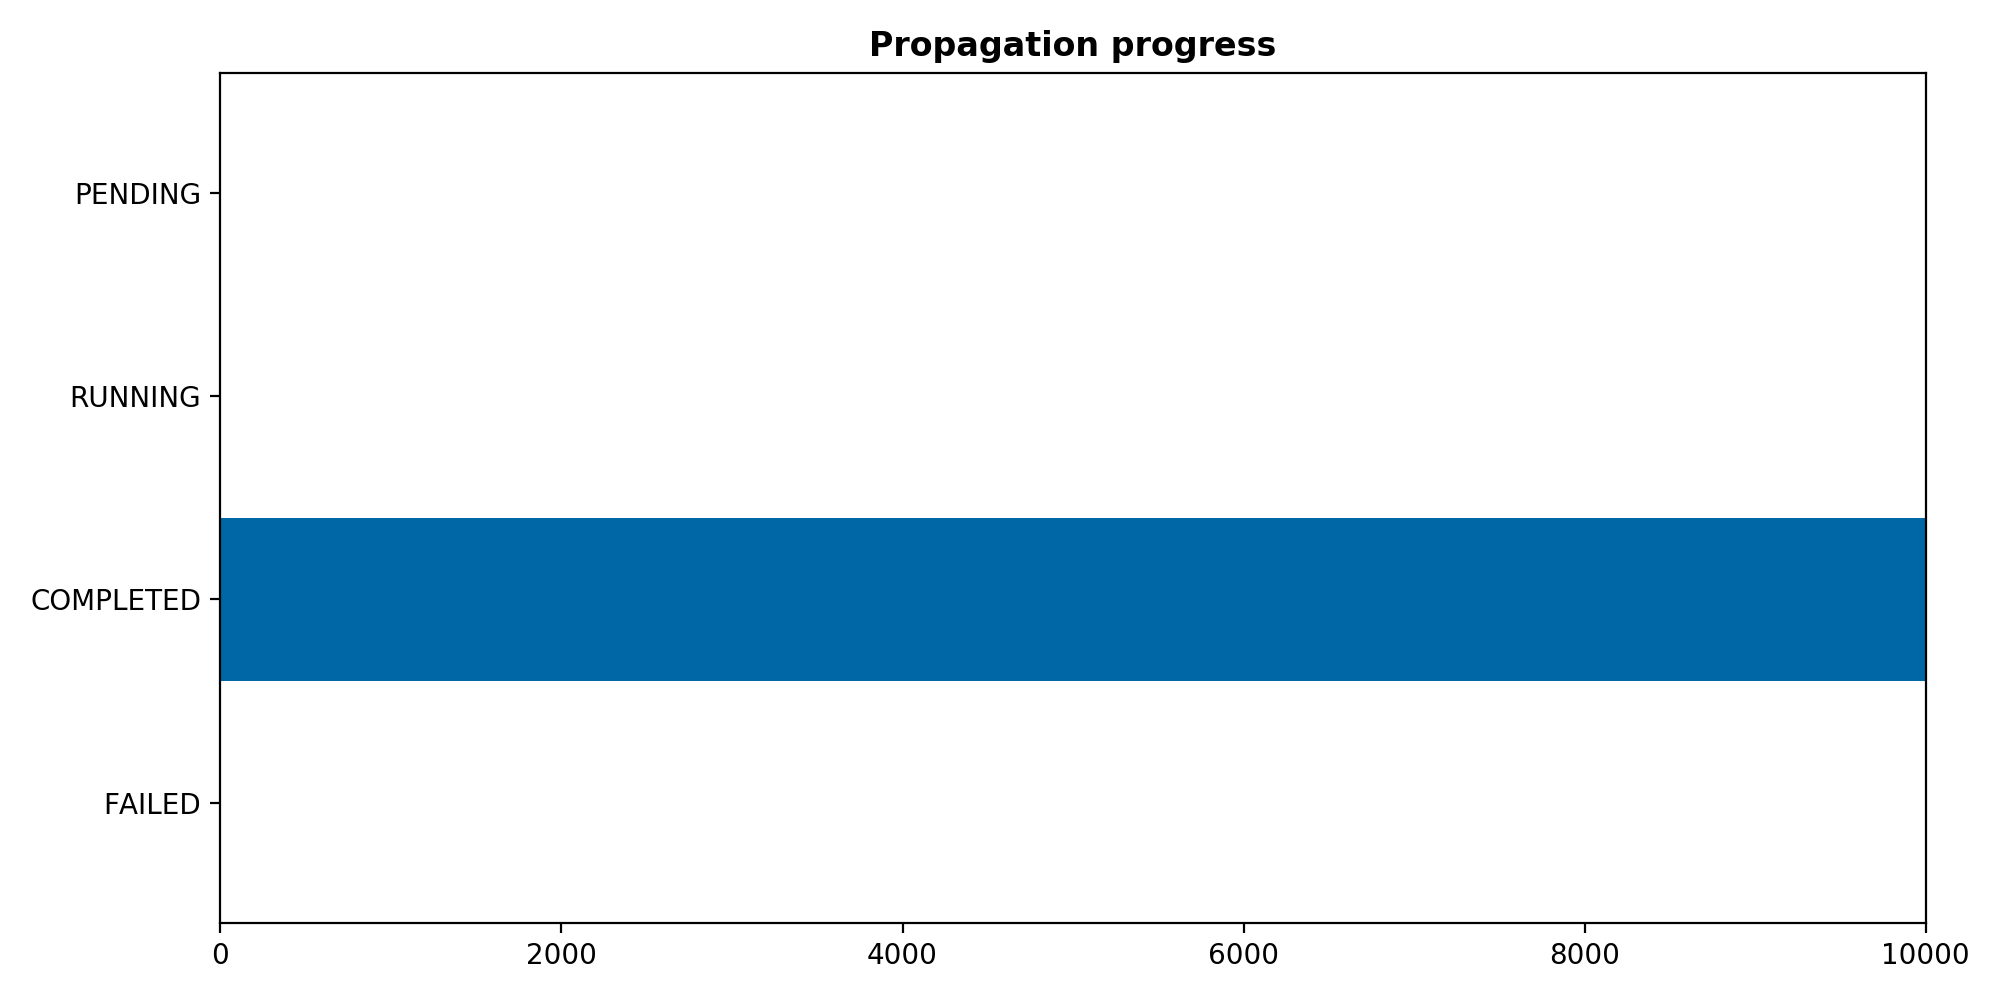

In [6]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(10, 5))
plt.ion()

num_batches = 10000
batches = [get_batch(i) for i in range(num_batches)]
batch_run_manager = BatchRunManager(service.get_batches_module(), batches)

fig.show()
fig.canvas.draw()

In [7]:
run_and_update_with_status(batch_run_manager, fig, ax)

Time elapsed: 0:17:58.209740
Completed runs: 10000
[1078.209817] Ran 10000 propagations.


Once the batches are all done propagating, you can view their results.

In [ ]:
for batch in batches:
    if batch.get_calc_state() == 'FAILED':
        error = 'unknown error'
        if batch.get_results() is not None and batch.get_results().get_parts()[0] is not None:
            error = batch.get_results().get_parts()[0].get_error()
        print('Batch %s failed: %s' % (batch.get_uuid(), error))
    else:
        final_state_vector = batch.get_results().get_end_state_vector()
        print('Batch %s ended at %s' % (batch.get_uuid(), final_state_vector))

That's it! Please clean up by running the following:

In [8]:
service.teardown()

Cleaning up working project 91d1c105-08de-47bb-905a-c8038eeccde6...
Encountered error 502 calling delete on /project/91d1c105-08de-47bb-905a-c8038eeccde6?token=1KT0bImQ83b2vEhDwPF0PZevYu92. Retrying (attempt 2)
Encountered error 503 calling delete on /project/91d1c105-08de-47bb-905a-c8038eeccde6?token=1KT0bImQ83b2vEhDwPF0PZevYu92. Retrying (attempt 3)
Encountered error 503 calling delete on /project/91d1c105-08de-47bb-905a-c8038eeccde6?token=1KT0bImQ83b2vEhDwPF0PZevYu92. Retrying (attempt 4)
Encountered error 503 calling delete on /project/91d1c105-08de-47bb-905a-c8038eeccde6?token=1KT0bImQ83b2vEhDwPF0PZevYu92. Retrying (attempt 5)


RuntimeError: Server status code: 503